#  TP M2 IARF-Rodeco

**Auteurs :** BEZIA Ayoub; MEKKID  OUSSAMA

**Année :** 2018-2019

Le but de cette séance est d'évaluer vos compétences sur un projet d'apprentissage profond en utilisant un nouveau corpus.

Contrairement aux séances précédentes, nous allons travailler cette fois-ci sur un corpus audio contenant 10 classes (craquemens de feu, tic-tac d'une horloge, le bruit d'un coq, etc...).

Les fichiers audio sont convertis en spectrogramme, une représentation temps/fréquence du signal qui peut être vue comme une image.

**La méthodologie reste la même et ne change absolument pas par rapport aux séances précédentes ! Toutes les méthodes vues durant les séances précédentes peuvent donc être réapliquées ici.**

## Gestion des pré-requis avant de commencer le contrôle

__Afin de ne pas perdre du temps sur les exécutions de chaque cellule du notebook, vous pouvez tout exécuter en allant dans le menu *Exécution* puis *Tout exécuter*__

### Importation des bibliothèques

Premièrement, faisons les importations nécessaires

In [0]:
import os
import random
import requests
import zipfile

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

import numpy as np
import matplotlib.pyplot as plt

Installation de la bibliothèque **librosa** qui va se charger d'ouvrir les fichiers audio et d'en extraire le spectrogramme qui sera traité ensuite comme une image dans la suite.

In [31]:
!pip install librosa
import librosa
import librosa.display

Vérifier bien que Keras utilise le GPU pour les calculs.
Si ce n'est pas le cas, il faut aller dans Exéction > Modifier le type d'exécution > Accélérateur Matériel > GPU

In [32]:
if K.backend() == "tensorflow":
    from tensorflow.python.client import device_lib
    print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16738397276783930505
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11280557671
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9377501414930766340
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


### Fixer la seed

On fixe la seed afin de retrouver les mêmes résultats à chaque lancement du programme.

In [0]:
from numpy.random import seed
seed(123) # On peut utiliser n'importe quelle nombre

from tensorflow import set_random_seed
set_random_seed(1234)

### Chargement du corpus

Le corpus est constitué de 10 concepts audio qui sont :
* **tronçonneuse** *(chainsaw)*
* **tic-tac d'une horloge** *(clock_tick)*
* **craquement de feu** *(crackling_fire)*
* **pleurs de bébé** *(crying_baby)*
* **chien** *(dog)*
* **hélicoptère** *(helicopter)*
* **pluie** *(rain)*
* **coq** *(rooster)*
* **bruit des vagues** *(sea_waves)*
* **éternuement** *(sneezing)*

Nous voulons classifier les différents fichiers audio suivant les 10 classes.

#### Téléchargement du corpus

On récupère tout d'abord le corpus

In [34]:
!wget -O dataset.zip https://www.irit.fr/filez/reyxjnc/download
!unzip -qq dataset.zip -d data/
!rm dataset.zip

--2018-10-22 17:54:59--  https://www.irit.fr/filez/reyxjnc/download
Resolving www.irit.fr (www.irit.fr)... 141.115.28.2
Connecting to www.irit.fr (www.irit.fr)|141.115.28.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128685900 (123M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>] 122.72M  21.3MB/s    in 6.5s    

2018-10-22 17:55:06 (18.8 MB/s) - ‘dataset.zip’ saved [128685900/128685900]

replace data/test/chainsaw/1-64398-B-41.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

La base de données téléchargée est stockée dans :

```
./data
```
Vous pouvez visualiser l'arborescence des données dans la colonne de gauche sous l'onglet *Fichiers* et en cliquant sur le bouton *actualiser* si les données n'apparaissent pas.

In [0]:
base_dir = './data'

#### Chargement du corpus dans la mémoire

La fonction **load_dataset** permet de charger les données d'apprentissage ou les données de test en mémoire.

**Attention :** le chargement est un peu long (environ 2min)

In [0]:
idx_to_classes = ['chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby',
                  'dog', 'helicopter', 'rain', 'rooster', 'sea_waves',
                  'sneezing']


def load_dataset(path):
    spec = []
    labels = []
    for idx, label in enumerate(idx_to_classes):
        with os.scandir(os.path.join(path, label)) as it:
            for entry in it:
                if (not entry.name.startswith('.')
                        and entry.name.endswith('.wav')):
                    # load audio
                    y, sr = librosa.load(entry.path)
                    # convert audio to melspectrogram
                    spec.append(librosa.feature.melspectrogram(y, sr,
                                                              n_fft=2048,
                                                              hop_length=512,
                                                              power=2.0))
                    # add associated label
                    labels.append(idx)

    # mélange les données 
    #combined = list(zip(spec, labels))
    #random.shuffle(combined)
    #spec, labels = zip(*combined)
    return np.array(spec), np.array(labels)

In [106]:
# Le chargement des données est assez long : un peu moins de 2min
%%time

print("Chargement du corpus d'apprentissage")
train_dir = os.path.join(base_dir, 'train')
x_train, y_train = load_dataset(train_dir)
x_train_prev = x_train
y_train_prev = y_train

print("Chargement du corpus de test")
test_dir = os.path.join(base_dir, 'test')
x_test, y_test = load_dataset(test_dir)
x_test_prev = x_test
y_test_prev = y_test

Chargement du corpus d'apprentissage
Chargement du corpus de test
CPU times: user 2min 33s, sys: 32.2 s, total: 3min 5s
Wall time: 2min 20s


#### Taille du corpus

Affichage de la taille du corpus. Pour cela, il suffit de compter le nombre d'images qu'il y a dans les dossiers correspondant à chaque label aussi bien dans le corpus d'apprentissage que dans le corpus de test.

In [39]:
# Affichage du nombre d'exemples totales dans le corpus
print('Taille du corpus total')
print('\t• train :', len(x_train), 'exemples')
print('\t• test :', len(x_test), 'exemples')

# Affichage de la taille des images et des labels dans le corpus 
print('\nTaille des données d\'apprentissage')
print('\t• X_train (images) :', x_train.shape)
print('\t• y_train (labels) :', y_train.shape)

print('\nTaille des données de test')
print('\t• X_test (images) :', x_test.shape)
print('\t• y_test (labels) :', y_test.shape)

Taille du corpus total
	• train : 320 exemples
	• test : 80 exemples

Taille des données d'apprentissage
	• X_train (images) : (320, 128, 216)
	• y_train (labels) : (320,)

Taille des données de test
	• X_test (images) : (80, 128, 216)
	• y_test (labels) : (80,)


**Correspondance ID du label / signification**

Définition de la liste *idx_to_classes* permettant à partir de la valeur du label de retrouver sa signification

In [40]:
idx_to_classes = ['chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby',
                  'dog', 'helicopter', 'rain', 'rooster', 'sea_waves',
                  'sneezing']

# du corpus d'apprentissage
print("Affichage de la correspondance des labels :")
for i in range(10):
    n = random.randint(0, len(y_train)-1)
    print('• y_train[' + str(n) + '] =', y_train[n], '->', idx_to_classes[y_train[n]])

Affichage de la correspondance des labels :
• y_train[277] = 8 -> sea_waves
• y_train[242] = 7 -> rooster
• y_train[275] = 8 -> sea_waves
• y_train[1] = 0 -> chainsaw
• y_train[191] = 5 -> helicopter
• y_train[195] = 6 -> rain
• y_train[210] = 6 -> rain
• y_train[261] = 8 -> sea_waves
• y_train[94] = 2 -> crackling_fire
• y_train[71] = 2 -> crackling_fire


**Affichage des images**

On affiche maintenant quelques images issues du corpus avec le label associé

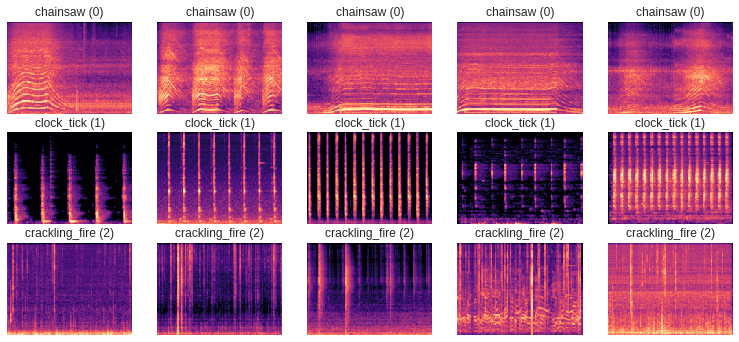

In [66]:
plt.figure(figsize=(13,20))

n = 0
for i in range(3):
    for j in range(5):
        # récupération d'une image et de son label associé
        img, target = x_train[n+j], y_train[n+j]
        # affiche du spectrogramme
        plt.subplot(10,5,i*5+j+1)
        img = librosa.power_to_db(img)
        librosa.display.specshow(img, cmap='magma')
        # ajout d'un titre à l'image
        plt.title('{} ({})'.format(idx_to_classes[target], target))
        #plt.colorbar(format='%+2.0f dB')
    n += 32
              
plt.show()

## Classification de fichiers audio en utilisant de l'apprentissage profond

Maintenant c'est à vous de jouer, vous devez implémenter différentes architectures de réseaux de neurones à partir de vos connaissances et ceux que vous avez vu dans les séances précédentes.

Pour cela, vous devriez :
* faire attention au format des données en entrée (reshape des images, transformer un vecteur en one hot encoding, etc.) ;
* déclarer l'architecture ;
* compiler le modèle ;
* lancer l'apprentissage ;
* évaluer le modèle ;
* lancer la prédiction sur quelques images de tests.

Pour l'évalutation du modèle, nous utiliserons nos données de tests ce qui n'est normalement pas rigoureux.

### Réseau MLP

Dans cette section, vous allez devoir implémenter un réseau dense à 1 ou plusieurs couches cachées

Pretraitement des données 
1-conversion a float 32

In [0]:
# Conversion des données en type float32:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#print(x_train[0])
#plt.imshow(x_train[5])

encodage one hot

In [45]:
# one-hot encoding
nb_classes = 10
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

# affichage de l'encodage des labels sur les 10 premières données
# du corpus d'apprentissage
print("Affichage de l'encodage des labels :")
for i in range(100,110):
    print('• y_train[' + str(i) + '] =', y_train[i], '->', Y_train[i])

Affichage de l'encodage des labels :
• y_train[100] = 3 -> [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
• y_train[101] = 3 -> [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
• y_train[102] = 3 -> [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
• y_train[103] = 3 -> [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
• y_train[104] = 3 -> [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
• y_train[105] = 3 -> [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
• y_train[106] = 3 -> [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
• y_train[107] = 3 -> [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
• y_train[108] = 3 -> [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
• y_train[109] = 3 -> [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


Normalisation des données

In [46]:
# définition du rééchelonnage
def reechelonnage(X_train, X_test):
    # à faire
  
    X_train, X_test = X_train/255, X_test/255
    return X_train, X_test
  # définition de la standardisation
def standardisation(X_train, X_test):
    # à faire
    return (X_train-np.mean(X_train))/np.var(X_train), (X_test-np.mean(X_test))/np.var(X_test)
  # sans normalisation
#X_train, X_test = x_train, x_test

# normalisation des données
X_train, X_test = reechelonnage(x_train, x_test)
#APPLATISSEMENT DES DONNEES
def img_reshape(X_train, X_test):
    X_train = X_train.reshape((-1,128*216))
    X_test = X_test.reshape((-1,128*216))
    return X_train, X_test
  
 #APPLICATION
X_train, X_test = img_reshape(X_train, X_test)

print('\nTaille des données :')
print('\t• X_train :', X_train.shape)
print('\t• X_test :', X_test.shape)


Taille des données :
	• X_train : (320, 27648)
	• X_test : (80, 27648)


In [68]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5,
       5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8,
       8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9])

*italicized text*#### Création et apprentissage d'un modèle MLP


In [69]:
# Model initialization:
model = Sequential()

# Notre premier modele avec une seule couche cachée de 50 neurones.

# Pour le construire, ajouter une couche Dense. 

# Attention vous devez préciser la dimension des inputs pour cette première couche :
input_D=X_train.shape[1]
#print(input_dim)
model.add(Dense(100,input_dim=input_D))

# Ensuite ajouter une activation de type ReLu :

model.add(Activation('relu'))

######

#model.add(Dense(25))
#model.add(Activation('relu'))


###


# Ajouter maintenant la couche de sortie avec le bon nombre de neurones et la bonne fonction d'activation :

model.add(Dense(10))
model.add(Activation('softmax'))

# Compléter la ligne suivante en choisissant la bonne fonction de coût.
# Voir la liste des fonctions de coût disponibles ici :
# https://keras.io/losses/

model.compile(loss='categorical_crossentropy', 
            optimizer='adam', 
            metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 100)               2764900   
_________________________________________________________________
activation_12 (Activation)   (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                1010      
_________________________________________________________________
activation_13 (Activation)   (None, 10)                0         
Total params: 2,765,910
Trainable params: 2,765,910
Non-trainable params: 0
_________________________________________________________________


**Apprentissage**

In [70]:
%%time
epochs = 30 
batch_size = 32

# compléter les arguments nécessaires ci-dessous
history = model.fit(X_train , Y_train ,batch_size=batch_size , epochs=epochs , verbose=2, validation_data=(X_test,Y_test))

Train on 320 samples, validate on 80 samples
Epoch 1/30
 - 0s - loss: 2.0027 - acc: 0.2656 - val_loss: 1.7676 - val_acc: 0.3250
Epoch 2/30
 - 0s - loss: 1.3156 - acc: 0.6500 - val_loss: 1.6675 - val_acc: 0.4500
Epoch 3/30
 - 0s - loss: 0.9927 - acc: 0.7844 - val_loss: 1.7212 - val_acc: 0.5125
Epoch 4/30
 - 0s - loss: 0.8139 - acc: 0.8562 - val_loss: 1.7388 - val_acc: 0.4500
Epoch 5/30
 - 0s - loss: 0.6995 - acc: 0.9000 - val_loss: 1.9553 - val_acc: 0.4500
Epoch 6/30
 - 0s - loss: 0.6743 - acc: 0.9219 - val_loss: 1.8974 - val_acc: 0.5000
Epoch 7/30
 - 0s - loss: 0.5583 - acc: 0.9281 - val_loss: 2.0801 - val_acc: 0.4500
Epoch 8/30
 - 0s - loss: 0.5118 - acc: 0.9281 - val_loss: 2.1184 - val_acc: 0.4375
Epoch 9/30
 - 0s - loss: 0.4687 - acc: 0.9375 - val_loss: 2.1412 - val_acc: 0.4625
Epoch 10/30
 - 0s - loss: 0.4293 - acc: 0.9375 - val_loss: 2.3299 - val_acc: 0.4125
Epoch 11/30
 - 0s - loss: 0.3986 - acc: 0.9437 - val_loss: 2.4735 - val_acc: 0.4250
Epoch 12/30
 - 0s - loss: 0.3689 - acc: 

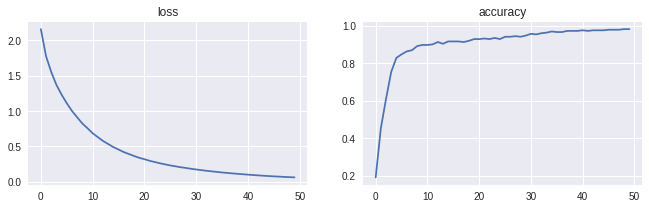

In [56]:
plt.figure(figsize=(11,3))

# affichage de la valeur de la fonction de perte
plt.subplot(1,2,1)
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

# affichage de la précision de notre réseau sur les données d'apprentissage
plt.subplot(1,2,2)
plt.plot(history.epoch,history.history['acc'])
plt.title('accuracy');

**Remarque : on a eu des bonnes resultas**

Inférence des données de tests


In [57]:
%%time
scores = model.evaluate(X_test, Y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 35.00%
CPU times: user 75.1 ms, sys: 5.97 ms, total: 81.1 ms
Wall time: 80.1 ms


In [0]:
def show_failures(predictions, trueclass=None, predictedclass=None, maxtoshow=10):
    rounded = np.argmax(predictions, axis=1)
    errors = rounded!=y_test
    print('La prédiction est affichée en premier et entre parenthèses, le vrai label.')
    ii = 0
    plt.figure(figsize=(maxtoshow+maxtoshow/4, 1))
    for i in range(x_test.shape[0]):
        if ii>=maxtoshow:
            break
        if errors[i]:
            if trueclass is not None and y_test[i] != trueclass:
                continue
            if predictedclass is not None and rounded[i] != predictedclass:
                continue
            plt.subplot(1, maxtoshow, ii+1)
            plt.axis('off')
            plt.imshow(x_test[i,:,:], cmap="gray")
            plt.title("{}\n({})".format(idx_to_classes[rounded[i]], idx_to_classes[y_test[i]]))
            ii = ii + 1

La prédiction est affichée en premier et entre parenthèses, le vrai label.


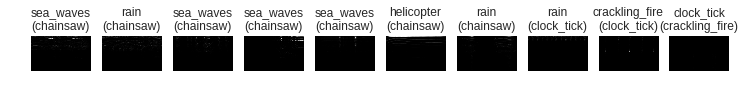

In [74]:
predictions = model.predict(X_test)

show_failures(predictions)

La prédiction est affichée en premier et entre parenthèses, le vrai label.


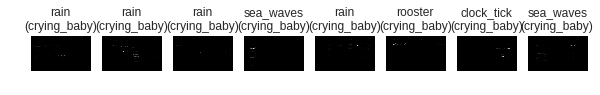

In [64]:
# pour afficher les erreurs du chiffre 1 uniquement :
show_failures(predictions, trueclass=3)

In [0]:
from sklearn.metrics import confusion_matrix

print('Confusion matrix (rows: true classes; columns: predicted classes):'); print()
cm=confusion_matrix(y_test, np.argmax(predictions, axis=1), labels=list(range(10)))
print(cm); print()

print('Classification accuracy for each class:'); print()
for i,j in enumerate(cm.diagonal()/cm.
                     sum(axis=1)):
    print("%d: %.4f" % (i,j))

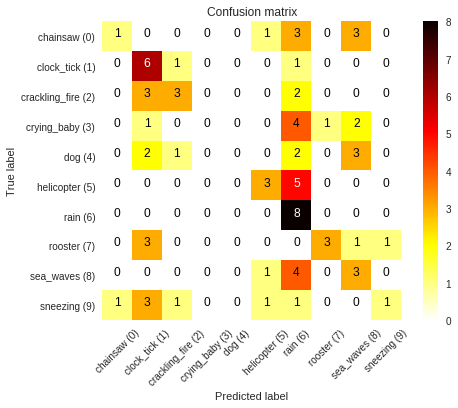

In [66]:
# afficage de la matrice de confusion dans un autre format
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.hot_r)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(idx_to_classes))
plt.grid(None)
classes_name = zip(idx_to_classes, list(range(len(idx_to_classes))))
classes_name = ['{} ({})'.format(*i) for i in classes_name]
plt.xticks(tick_marks, classes_name, rotation=45)
plt.yticks(tick_marks, classes_name)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()



### Réseau convolutif

Maintenant, vous allez implémenter un réseau convolutif.

In [108]:
x_train = x_train_prev
y_train = y_train_prev
x_test = x_test_prev
y_test = y_test_prev

img_rows=128
img_cols = 216
batch_size = 32
epochs = 40

data_format = keras.backend.image_data_format()
if(data_format == 'channels_first'):
  input_shape = (1, img_rows, img_cols)
else:
  input_shape = (img_rows, img_cols, 1)


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255  
  
x_train = x_train.reshape(x_train.shape[0], *input_shape)
x_test = x_test.reshape(x_test.shape[0], *input_shape)

y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)
  
num_classes = 10  
model = Sequential()


model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.summary()

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
         validation_data=(x_train,y_train))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 128, 216, 32)      320       
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 126, 214, 64)      18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 63, 107, 64)       0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 63, 107, 64)       0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 431424)            0         
_________________________________________________________________
dense_43 (Dense)             (None, 128)               55222400  
_________________________________________________________________
dropout_32 (Dropout)         (None, 128)               0         
__________

In [97]:
x_train.shape

(320, 128, 216)

In [81]:
x_test.shape

(80, 128, 216)